# Deep Learning Portfolio 3

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|michalreszkagniecki|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [Objectdetectie](#Model1)
    - [Ondertiteling van afbeeldinge](#Model2)
    - [Beeldgeneratie](#Model3)
    - [Implementatie](#Model4)
- [Results](#results)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)
- [Submission functie](#Submission-functie)
- [HTML functie](#HTML-functie)

In [ ]:
#!pip install keras-tuner --upgrade
# !pip install wordcloud
# !pip install tqdm


In [ ]:
!pip install --upgrade datasets

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 61.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import random
import torch
import glob
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datasets import load_dataset

## Data Overview

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data importeren

In [5]:
img_train = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Train"
img_test = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test"


In [ ]:
hnm_dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/323 [00:00<?, ?B/s]

train-00000-of-00011.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00001-of-00011.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

train-00002-of-00011.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00003-of-00011.parquet:   0%|          | 0.00/335M [00:00<?, ?B/s]

train-00004-of-00011.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

train-00005-of-00011.parquet:   0%|          | 0.00/321M [00:00<?, ?B/s]

train-00006-of-00011.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

train-00007-of-00011.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

train-00008-of-00011.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

train-00009-of-00011.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

train-00010-of-00011.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12437 [00:00<?, ? examples/s]

In [ ]:
sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 3 Datasets/submission_example.csv')

## Exploratory Data Analysis

#### Train data

In [ ]:
# ImageDataGenerator aanmaken
datagen = ImageDataGenerator(rescale=1./255)  # normaliseer de beelden

# Laad de data automatisch uit submappen
train_data = datagen.flow_from_directory(
    img_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Klassen en hun indexen:", train_data.class_indices)

#### Test data

In [ ]:
test_data = datagen.flow_from_directory(
    img_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Klassen en hun indexen:", test_data.class_indices)


## Voorbeeld afbeeldingen

### Train afbeeldingen

In [ ]:
def toon_afbeeldingen_uit_batch(data, num_images):
    """
    Toont een aantal afbeeldingen uit een batch van een ImageDataGenerator.

    Parameters:
    - data: de ImageDataGenerator (flow_from_directory)
    - num_images: het aantal afbeeldingen om te tonen
    """
    # Haal een batch op
    images, labels = next(data)

    # Plot de afbeeldingen
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
train_data_show = toon_afbeeldingen_uit_batch(train_data, 6)

### Test afbeeldingen

In [ ]:
test_data_show = toon_afbeeldingen_uit_batch(test_data,6)

## Breedte & Hoogte verdeling

In [ ]:
def verzamel_afmetingen(data):
    sizes = []
    for label in os.listdir(data):
        label_path = os.path.join(data, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(label_path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            sizes.append(img.size)
                    except:
                        continue
    return sizes

afmetingen = verzamel_afmetingen(img_train)

# Visualiseer

widths = [s[0] for s in afmetingen]
heights = [s[1] for s in afmetingen]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True)
plt.title("Breedteverdeling")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True)
plt.title("Hoogteverdeling")
plt.show()



De histogrammen laten zien dat bijna alle objecten precies dezelfde breedte en hoogte hebben. De breedte is altijd 400 eenheden en de hoogte is altijd 600 eenheden. Er is vrijwel geen verschil tussen de objecten, want de pieken in de histogrammen zijn heel scherp en geconcentreerd op die waarden.

Dit betekent dat de dataset erg uniform is. Mogelijk zijn de objecten bewust zo gemaakt of geselecteerd met vaste afmetingen, bijvoorbeeld omdat de afbeeldingen allemaal hetzelfde formaat hebben. Het ontbreken van variatie in breedte en hoogte is opvallend en kan invloed hebben op hoe een model leert, omdat het weinig verschillende vormen ziet.

## Controle op corrupte afbeeldingen

In [ ]:
def controleer_corruptie(data):
    fouten = []
    for root, dirs, files in os.walk(data):
        for name in files:
            if name.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, name)
                with Image.open(path) as img:
                        img.verify()

    return fouten

corrupt = controleer_corruptie(img_train)
print(f"Corrupt of onleesbare afbeeldingen gevonden: {len(corrupt)}")


De code controleert of er beschadigde of onleesbare afbeeldingen in de dataset zitten. Het resultaat geeft aan dat er geen corrupte afbeeldingen zijn gevonden. Dit betekent dat alle beelden goed leesbaar en bruikbaar zijn voor verdere verwerking.

## Voorbeeldbeelden met kleurverdeling

In [ ]:
images_dir = img_train + '/images'

In [ ]:
def toon_images_met_histogram(map_pad, aantal):
    # Pak alle afbeelding-bestanden in de map
    image_files = [f for f in os.listdir(map_pad) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    # if len(image_files) < aantal:
    #     print(f"Niet genoeg afbeeldingen in de map ({len(image_files)} gevonden, {aantal} gevraagd).")
    #     return

    # Kies random aantal afbeeldingen
    gekozen = random.sample(image_files, aantal)

    plt.figure(figsize=(12, 4 * aantal))

    for i, fname in enumerate(gekozen):
        path = os.path.join(map_pad, fname)
        img = cv2.imread(path)
        # if img is None:
        #     print(f"Kan {fname} niet laden!")
        #     continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r, g, b = cv2.split(img)

        # Toon afbeelding
        plt.subplot(aantal, 2, i*2 + 1)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')

        # Toon histogram
        plt.subplot(aantal, 2, i*2 + 2)
        plt.hist(r.ravel(), bins=256, color='r', alpha=0.5, label='Rood')
        plt.hist(g.ravel(), bins=256, color='g', alpha=0.5, label='Groen')
        plt.hist(b.ravel(), bins=256, color='b', alpha=0.5, label='Blauw')
        plt.title("RGB Histogram")
        plt.xlabel("Pixelwaarde")
        plt.ylabel("Aantal pixels")
        plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
toon_images_met_histogram(images_dir, 3)


De kleuren verschillen sterk per afbeelding. Dit zie je ook terug in de RGB-histogrammen. Elke afbeelding heeft een andere verdeling van rood, groen en blauw.

Sommige foto's hebben veel heldere kleuren zoals geel en groen, terwijl andere juist warme tinten bevatten zoals rood en bruin. Ook de hoeveelheid licht en schaduw speelt een rol.

De histogrammen laten zien welke kleuren het meest aanwezig zijn in de afbeelding. Hoge pieken in één kleur betekenen dat die kleur veel voorkomt. Als de pieken van rood en groen overlappen, zie je bijvoorbeeld veel geel.

De kleurverdeling is niet altijd gelijk. Elke afbeelding heeft zijn eigen sfeer en dominante kleuren, en dat zie je goed terug in de histogrammen. Dit kan invloed hebben op het model, omdat het model kleuren gebruikt als visuele informatie om objecten te herkennen. Grote kleurverschillen kunnen ervoor zorgen dat het model sommige objecten beter of juist slechter leert herkennen.

### Afbeeldingen met labels

In [ ]:
def toon_meerdere_afbeeldingen_met_bboxes(images_dir, labels_dir, class_dict, aantal):
    # Kies willekeurige afbeeldingen
    alle_afbeeldingen = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    gekozen_afbeeldingen = random.sample(alle_afbeeldingen, min(aantal, len(alle_afbeeldingen)))

    plt.figure(figsize=(6 * aantal, 6))

    for idx, gekozen_afb in enumerate(gekozen_afbeeldingen):
        naam_zonder_ext = os.path.splitext(gekozen_afb)[0]
        label_pad = os.path.join(labels_dir, f"{naam_zonder_ext}.txt")
        image_pad = os.path.join(images_dir, gekozen_afb)

        # Laad de afbeelding
        img = cv2.imread(image_pad)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Lees labelbestand en teken bounding boxes
        if os.path.exists(label_pad):
            with open(label_pad, 'r') as f:
                for line in f:
                    delen = line.strip().split()
                    class_id = int(delen[0])
                    cx, cy, bw, bh = map(float, delen[1:])

                    x1 = int((cx - bw / 2) * w)
                    y1 = int((cy - bh / 2) * h)
                    x2 = int((cx + bw / 2) * w)
                    y2 = int((cy + bh / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, class_dict[class_id], (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Plot afbeelding
        plt.subplot(1, aantal, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(gekozen_afb)

    plt.tight_layout()
    plt.show()

# Klassen
class_dict = {
    0: "sunglass", 1: "hat", 2: "jacket", 3: "shirt", 4: "pants",
    5: "shorts", 6: "skirt", 7: "dress", 8: "bag", 9: "shoe"
}




In [ ]:
# Gebruik:
labels_dir = img_train + '/labels'
toon_meerdere_afbeeldingen_met_bboxes(images_dir, labels_dir, class_dict, 3)

De labels zijn over het algemeen goed gedaan voor de kledingstukken en accessoires. De meeste objecten zijn duidelijk en correct gelabeld. Maar bij de schoenen is dat wat minder goed gegaan. Sommige schoenen zijn niet goed zichtbaar op de afbeelding of zijn niet helemaal juist gelabeld.

Dat kan een probleem zijn voor het model. Als de schoenen niet goed gelabeld zijn, wordt het voor het model moeilijker om te leren wat een schoen precies is. Hierdoor kan het model minder goed schoenen herkennen tijdens het testen. Dit kan de nauwkeurigheid van het model negatief beïnvloeden, vooral voor de klasse "schoen", ook al is dat de meest voorkomende klasse in de dataset.

Het is dus belangrijk om ook bij veelvoorkomende klassen te zorgen voor goede en duidelijke labels, zodat het model betrouwbare resultaten kan geven.

### De klassenverdeling in de labels

In [ ]:
def analyseer_klassenverdeling(label_dir):
    counter = Counter()
    for lbl in os.listdir(label_dir):
        if lbl.endswith(".txt"):
            with open(os.path.join(label_dir, lbl), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    counter[class_id] += 1
    return counter


verdeling = analyseer_klassenverdeling(labels_dir)

# Visualiseren
plt.figure(figsize=(10, 4))
sns.barplot(x=[class_dict[k] for k in verdeling.keys()], y=list(verdeling.values()))
plt.title("Klassenverdeling in trainingslabels")
plt.ylabel("Aantal objecten")
plt.xlabel("Klasse")
plt.xticks(rotation=45)
plt.show()


De staafdiagram laat zien hoe de objectklassen verdeeld zijn in de trainingslabels. Op de x-as staan de klassen en op de y-as het aantal objecten per klasse.

Schoenen komen het meest voor, met meer dan 2000 objecten. Daarna komen shirts met ongeveer 1500 objecten, gevolgd door tassen met 1200. Jassen en rokken hebben elk tussen de 700 en 800 objecten. Broeken en jurken hebben ongeveer 500 objecten. Korte broeken en zonnebrillen zijn minder vaak aanwezig, met ongeveer 350 en 300 objecten. Hoeden komen het minst voor, iets meer dan 250 keer.

De staafdiagram laat duidelijk zien dat de verdeling van klassen ongelijk is. Dit noemen we een ongebalanceerde dataset. Dat kan invloed hebben op het trainen van een model. Het model leert dan beter de veelvoorkomende klassen te herkennen en minder goed de zeldzame.

## Feature Engineering

## Modeling

### Objectdetectie

In [ ]:
# import os
# import shutil
# import random

# random.seed(42)

# # Originele train folders
# images_dir = f"{img_train}/images"
# labels_dir = f"{img_train}/labels"

# dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/'
# # Nieuwe mappen voor split
# train_images_dir = f'{dir}train/images'
# train_labels_dir = f'{dir}train/labels'
# val_images_dir = f'{dir}val/images'
# val_labels_dir = f'{dir}val/labels'

# os.makedirs(train_images_dir, exist_ok=True)
# os.makedirs(train_labels_dir, exist_ok=True)
# os.makedirs(val_images_dir, exist_ok=True)
# os.makedirs(val_labels_dir, exist_ok=True)

# # Alle afbeeldingen in train
# all_images = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# # Shuffle en split 80% train, 20% val
# random.shuffle(all_images)
# split_idx = int(len(all_images)*0.8)
# train_images = all_images[:split_idx]
# val_images = all_images[split_idx:]

# # Functie om bestanden te kopiëren
# def copy_files(file_list, src_images, src_labels, dst_images, dst_labels):
#     for file_name in file_list:
#         # kopieer afbeelding
#         shutil.copy(os.path.join(src_images, file_name), os.path.join(dst_images, file_name))
#         # kopieer label (zelfde naam maar .txt extensie)
#         label_name = os.path.splitext(file_name)[0] + '.txt'
#         shutil.copy(os.path.join(src_labels, label_name), os.path.join(dst_labels, label_name))

# # Kopieer train bestanden
# copy_files(train_images, images_dir, labels_dir, train_images_dir, train_labels_dir)
# # Kopieer val bestanden
# copy_files(val_images, images_dir, labels_dir, val_images_dir, val_labels_dir)


In [ ]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

In [ ]:
# Installeer dependencies van YOLOv5 (alleen nodig bij eerste keer)
%cd yolov5
!pip install -r requirements.txt
%cd ..


In [ ]:
# Pad naar het data.yaml bestand in de Colab-omgeving
yaml_file_path = '/content/data.yaml'

# Inhoud van het data.yaml bestand
yaml_content = """
train: /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/train/images
val: /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images


nc: 10
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']

"""

# Schrijf de inhoud naar het bestand
with open(yaml_file_path, 'w') as f:
    f.write(yaml_content)

print(f"'{yaml_file_path}' is aangepast.")

In [ ]:
!python /content/yolov5/train.py --data /content/data.yaml --weights yolov5m.pt --img 640 --epochs 50 --batch-size 32

In [ ]:
!python /content/yolov5/detect.py \
  --weights /content/yolov5/runs/train/exp/weights/best.pt \
  --source "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images" \
  --img 640 \
  --conf 0.25 \
  --save-txt \
  --project /content/yolov5/runs/detect \
  --name test_predictions \
  --exist-ok


In [ ]:
import os
import glob
import torch
import pandas as pd
from PIL import Image


# Zoek automatisch het pad naar best.pt (laatste experiment)
runs_dir = '/content/yolov5/runs/train'
list_of_runs = glob.glob(f'{runs_dir}/exp*')
if not list_of_runs:
    raise FileNotFoundError(f"Geen experimenten gevonden in {runs_dir}")

latest_run_dir = max(list_of_runs, key=os.path.getctime)
weights_path = os.path.join(latest_run_dir, 'weights/best.pt')
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Bestand niet gevonden: {weights_path}")

# Laad het getrainde YOLOv5-model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path, force_reload=True)
model.eval()  # Belangrijk voor evaluatie (geen dropout, batchnorm in eval mode)

# Pad naar testafbeeldingen en output-CSV
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images'
submission_output_path = '/content/submission.csv'

# Functie om voorspellingen te maken en te formatteren
def predict_model(image_path):
    results = model(image_path)
    img = Image.open(image_path)
    w_img, h_img = img.size

    preds = []
    if results.pred is not None and len(results.pred) > 0:
        for *box, conf, cls in results.pred[0].tolist():
            xmin, ymin, xmax, ymax = box
            cx = (xmin + xmax) / 2 / w_img
            cy = (ymin + ymax) / 2 / h_img
            bw = (xmax - xmin) / w_img
            bh = (ymax - ymin) / h_img
            preds.extend([
                int(cls),
                round(conf, 4),
                round(cx, 6),
                round(cy, 6),
                round(bw, 6),
                round(bh, 6)
            ])
    return preds

# Verwerk alle testafbeeldingen en maak predictions
all_test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
all_test_images.sort()

submission_data = {
    'id': [],
    'predictions': []
}

for img_name in all_test_images:
    img_path = os.path.join(test_images_dir, img_name)
    preds_list = predict_model(img_path)

    # Formatteer als comma-separated string in lijstnotatie: [0,0.99,0.5,...]
    preds_string = ",".join([str(p) for p in preds_list])
    preds_string = f'[{preds_string}]'

    # Verwijder de extensie (.jpg) voor de id-kolom
    image_id = os.path.splitext(img_name)[0]

    submission_data['id'].append(image_id)
    submission_data['predictions'].append(preds_string)

# Maak en exporteer de CSV
df_submission = pd.DataFrame(submission_data)
df_submission.to_csv(submission_output_path, index=False)

print(f'Submission bestand opgeslagen in: {submission_output_path}')


In [ ]:
# Pad naar jouw training run
results_csv_path1 = '/content/yolov5/runs/train/exp/results.csv'

# Lees het bestand
df = pd.read_csv(results_csv_path1)

df.tail()

25 epochs

In [ ]:
# Pad naar jouw training run
results_csv_path = '/content/yolov5/runs/train/exp2/results.csv'

# Lees het bestand
df = pd.read_csv(results_csv_path)

df

### Ondertiteling van afbeeldinge

### Beeldgeneratie

In [ ]:
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.src.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.src.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.src.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.src.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras

In [ ]:
from datasets import load_dataset
from PIL import Image
import requests
from io import BytesIO
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPTokenizer
import random

# Dataset laden
hnm_dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k")
data_split = hnm_dataset['train']


In [ ]:
print(data_split)

Dataset({
    features: ['text', 'image'],
    num_rows: 12437
})


In [6]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.3 MB/s eta 0:00:00


In [7]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [1]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sd3.py

--2025-06-17 14:51:03--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sd3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82063 (80K) [text/plain]
Saving to: ‘train_dreambooth_lora_sd3.py’

train_dreambooth_lo 100%[===================>]  80.14K  --.-KB/s    in 0.003s  

2025-06-17 14:51:04 (23.9 MB/s) - ‘train_dreambooth_lora_sd3.py’ saved [82063/82063]



In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/323 [00:00<?, ?B/s]

train-00000-of-00011.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00001-of-00011.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

train-00002-of-00011.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00003-of-00011.parquet:   0%|          | 0.00/335M [00:00<?, ?B/s]

train-00004-of-00011.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

train-00005-of-00011.parquet:   0%|          | 0.00/321M [00:00<?, ?B/s]

train-00006-of-00011.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

train-00007-of-00011.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

train-00008-of-00011.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

train-00009-of-00011.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

train-00010-of-00011.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12437 [00:00<?, ? examples/s]

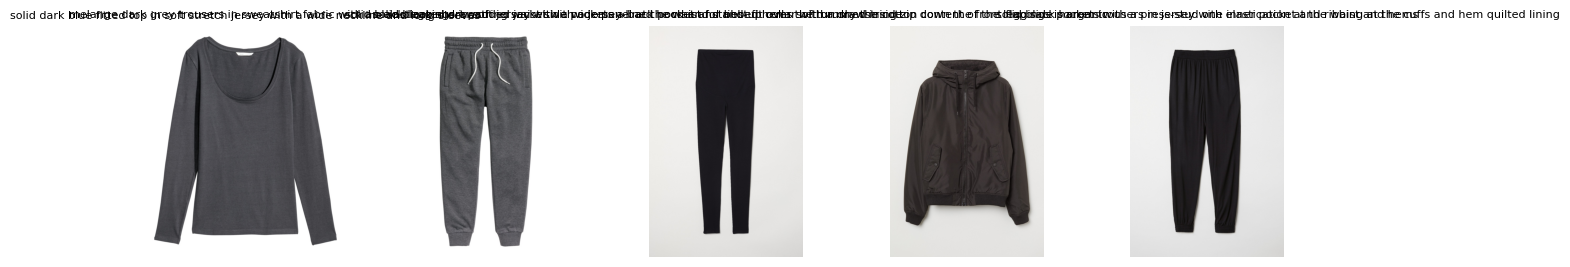

In [4]:
dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k", split="train")

def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        sample = dataset[i]
        image = sample["image"]
        caption = sample["text"]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(caption, fontsize=8)
        plt.axis("off")
    plt.show()

show_samples(dataset)

In [5]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [6]:
from huggingface_hub import notebook_login
notebook_login()


In [10]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py
!accelerate launch train_text_to_image_lora.py \
--pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
--dataset_name="tomytjandra/h-and-m-fashion-caption-12k" \
--caption_column="text" \
--resolution=512 \
--random_flip \
--train_batch_size=1 \
--gradient_accumulation_steps=4 \
--max_train_steps=1000 \
--learning_rate=1e-04 \
--max_grad_norm=1 \
--lr_scheduler="cosine" \
--lr_warmup_steps=0 \
--output_dir="hm-fashion-lora" \
--report_to=tensorboard \
--checkpointing_steps=500 \
--mixed_precision="fp16" \
--seed=42 \
--validation_prompt="a red floral summer dress on a mannequin, studio lighting" \
--num_validation_images=4 \
--push_to_hub


--2025-06-17 14:56:05--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41284 (40K) [text/plain]
Saving to: ‘train_text_to_image_lora.py.1’

train_text_to_image 100%[===================>]  40.32K  --.-KB/s    in 0.001s  

2025-06-17 14:56:05 (34.0 MB/s) - ‘train_text_to_image_lora.py.1’ saved [41284/41284]

2025-06-17 14:56:16.711232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750172176.732519    9099 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDN

In [11]:
from huggingface_hub import whoami
from pathlib import Path

output_dir = "hm-fashion-lora"
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"


In [12]:
from huggingface_hub import upload_folder, create_repo

# Maak repo aan
repo_id = create_repo(repo_id, exist_ok=True).repo_id

# Upload alleen de noodzakelijke bestanden (negeer checkpoints)
upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="H&M LoRA training voltooid 🚀",
    ignore_patterns=["step_*", "epoch_*"],
)


Uploading...:   0%|          | 0.00/3.47G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jaydendt/hm-fashion-lora/commit/821f71eb8953090f518a18f5ceea6106c5e4970a', commit_message='H&M LoRA training voltooid 🚀', commit_description='', oid='821f71eb8953090f518a18f5ceea6106c5e4970a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jaydendt/hm-fashion-lora', endpoint='https://huggingface.co', repo_type='model', repo_id='jaydendt/hm-fashion-lora'), pr_revision=None, pr_num=None)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

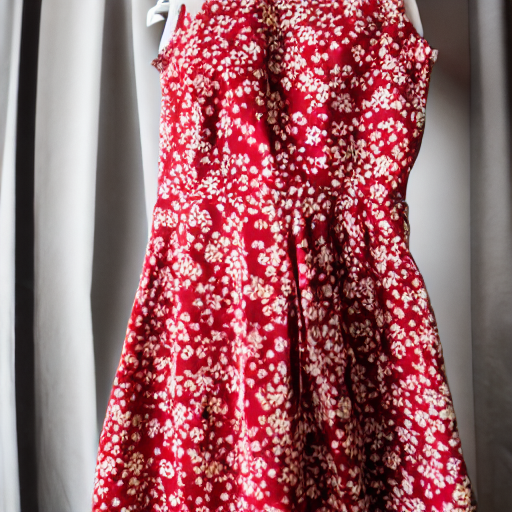

In [19]:
import torch
from diffusers import StableDiffusionPipeline

# Laad het LoRA-model gebaseerd op Stable Diffusion 1.5
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

# Laad jouw LoRA-gewichten
pipe.load_lora_weights(repo_id)

# pipe.load_lora_weights(output_dir)

# Genereer een afbeelding
prompt = "a red floral summer dress on a mannequin, studio lighting"
image = pipe(prompt=prompt, num_inference_steps=30).images[0]
display(image)


  0%|          | 0/50 [00:00<?, ?it/s]

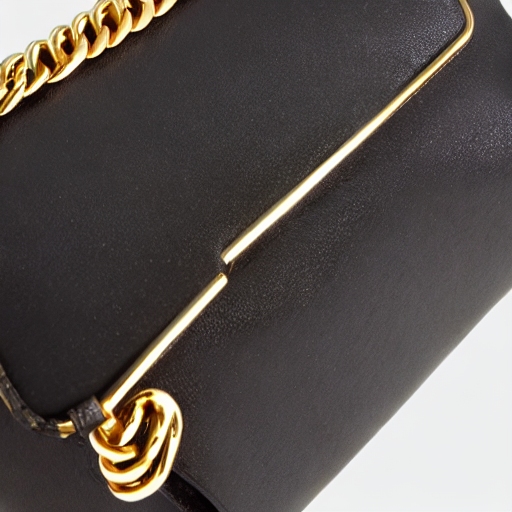

  0%|          | 0/50 [00:00<?, ?it/s]

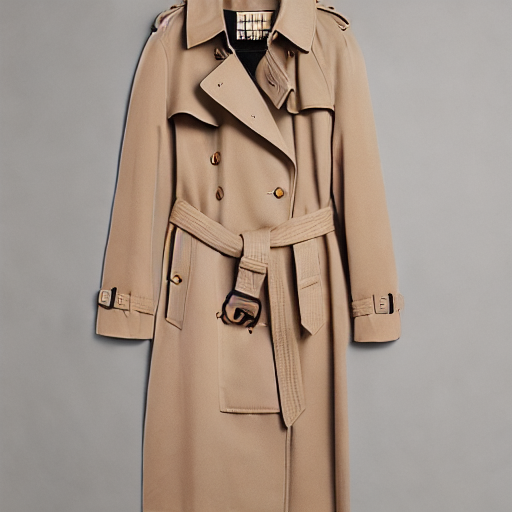

  0%|          | 0/50 [00:00<?, ?it/s]

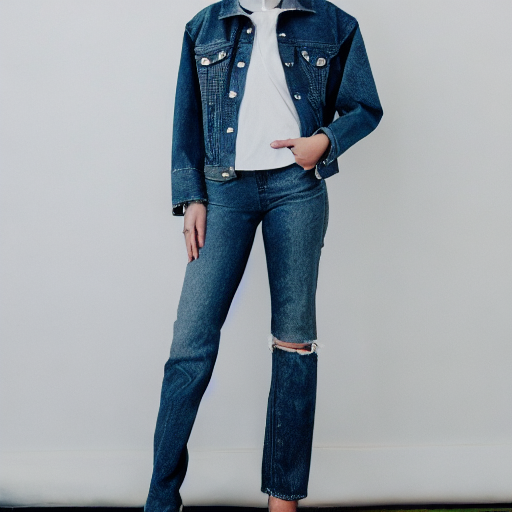

  0%|          | 0/50 [00:00<?, ?it/s]

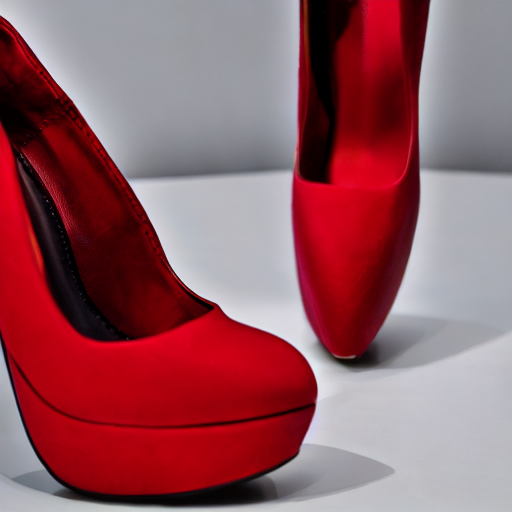

In [18]:
prompts = [
    "a black leather handbag with golden chains",
    "a stylish beige trench coat, studio lighting",
    "a blue denim jacket on a white background",
    "a pair of red high heels on a display stand"
]

for prompt in prompts:
    image = pipe(prompt).images[0]
    display(image)


### Implementatie

### Scoren:

|Model|Notebook|Kaggle|
|----|------|------|
||||
||||
||||
||||

#### Bevindingen modellen

## Conclusion & Advice

## Sources

### Submission functie

In [ ]:
def create_submission(pred, df_test, filename, label_encoder):
    """
    Creates a submission file for Kaggle test data with genre predictions.

    Args:
        pred (np.ndarray): Predicted probabilities or class indices.
        df_test (pd.DataFrame): Test dataframe containing filenames.
        filename (str): Output CSV filename (must include .csv).
        label_encoder (LabelEncoder): Trained label encoder to decode genre indices.

    Returns:
        pd.DataFrame: Submission dataframe.
    """
    # Als pred probabilities bevat → neem hoogste waarschijnlijkheid
    if pred.ndim > 1 and pred.shape[1] > 1:
        pred_classes = np.argmax(pred, axis=1)
    else:
        pred_classes = pred.reshape(-1)

    # Decode genre-namen
    genre_labels = label_encoder.inverse_transform(pred_classes[:len(df_test)])

    # Maak het submission DataFrame
    submission_df = pd.DataFrame({
        'filename': df_test['filename'].values[:len(genre_labels)],
        'genre': genre_labels
    })

    # Sla op
    submission_df.to_csv(filename, index=False)

    return submission_df


In [ ]:
# create_submission(y_pred, df_test, 'test.csv', le)

### Html

In [ ]:
# Upload ipynb
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")